## 摄像头预测-OpenCV

In [2]:
import os
os.chdir('../seg-2/mmsegmentation')

In [3]:
import time
import numpy as np
import cv2

import torch

import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
from mmseg.apis import init_model, inference_model

from mmseg.datasets.ade import ADE20KDataset
from mmseg.datasets.cityscapes import CityscapesDataset

### 模型设置选择

In [4]:
def config(dataset, model):
    if dataset == 'cityscapes':
        if model == 'UNet':
            # Unet
            config_file = 'configs/unet/unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/unet/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth'
        elif model == 'DeepLabV3+':
            # DeepLabV3+, R-50-D8	512x1024
            config_file = 'configs/deeplabv3plus/deeplabv3plus_r50-d8_4xb2-80k_cityscapes-512x1024.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x1024_80k_cityscapes/deeplabv3plus_r50-d8_512x1024_80k_cityscapes_20200606_114049-f9fb496d.pth'
        elif model == 'FastSCNN':
            # FastSCNN
            config_file = 'configs/fastscnn/fast_scnn_8xb4-160k_cityscapes-512x1024.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/fast_scnn/fast_scnn_lr0.12_8x4_160k_cityscapes/fast_scnn_lr0.12_8x4_160k_cityscapes_20210630_164853-0cec9937.pth'
        elif model == 'SegFormer':
            # SegFormer, MIT-B5	1024x1024	
            config_file = 'configs/segformer/segformer_mit-b5_8xb1-160k_cityscapes-1024x1024.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'
        elif model == 'Mask2Former':
            # Mask2Former, Swin-B (in22k)	512x1024	
            config_file = 'configs/mask2former/mask2former_swin-b-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-b-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024/mask2former_swin-b-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221203_045030-9a86a225.pth'
    elif dataset == 'ade20k':
        if model == 'DeepLabV3+':
            config_file = 'configs/deeplabv3plus/deeplabv3plus_r50-d8_4xb4-80k_ade20k-512x512.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'
        elif model == 'pspnet':
            config_file ='configs/pspnet/pspnet_r50-d8_4xb4-80k_ade20k-512x512.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_160k_ade20k/pspnet_r50-d8_512x512_160k_ade20k_20200615_184358-1890b0bd.pth'
        elif model == 'SegFormer':
            config_file = 'configs/segformer/segformer_mit-b5_8xb2-160k_ade20k-512x512.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_512x512_160k_ade20k/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth'
        elif model == 'MaskFormer':
            config_file = 'configs/maskformer/maskformer_swin-s_upernet_8xb2-160k_ade20k-512x512.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/maskformer/maskformer_swin-s_upernet_8xb2-160k_ade20k-512x512/maskformer_swin-s_upernet_8xb2-160k_ade20k-512x512_20221115_114710-723512c7.pth'
        elif model == 'Mask2Former':
            config_file = 'configs/mask2former/mask2former_swin-b-in22k-384x384-pre_8xb2-160k_ade20k-640x640.py'
            checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-b-in22k-384x384-pre_8xb2-160k_ade20k-640x640/mask2former_swin-b-in22k-384x384-pre_8xb2-160k_ade20k-640x640_20221203_235230-7ec0f569.pth'
        
    return config_file, checkpoint_file

In [5]:
def config_palette(dataset):
    if dataset == 'cityscapes':
        METAINFO = CityscapesDataset.METAINFO
        palette = [[class_name, color] for class_name, color in zip(METAINFO['classes'], METAINFO['palette'])]
    elif dataset == 'ade20k':
        METAINFO = ADE20KDataset.METAINFO
        palette = [[class_name, color] for class_name, color in zip(METAINFO['classes'], METAINFO['palette'])]
    elif dataset == 'watermelon':
        palette = [
            ['background', [127,127,127]],
            ['red', [0,0,200]],
            ['green', [0,200,0]],
            ['white', [144,238,144]],
            ['seed-black', [30,30,30]],
            ['seed-white', [8,189,251]]]

    palette_dict = {}
    for idx, each in enumerate(palette):
        palette_dict[idx] = each[1]

    return palette_dict

### 调用摄像头，处理帧

In [6]:
def process_frame(img_bgr, model, palette_dict):

    # 记录该帧开始处理的时间
    start_time = time.time()

    # 语义分割预测
    result = inference_model(model, img_bgr)
    pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')

    # 透明度，越大越接近原图
    opacity = 0.4

    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)

    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    scaler = 1 # 文字大小
    FPS_string = 'FPS {:.2f}'.format(FPS) # 写在画面上的字符串
    img_bgr = cv2.putText(pred_viz, FPS_string, (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)

    return img_bgr

### 模型设置，抓拍一张，分割

In [30]:
def capture_and_process_image(dataset, model_name, output_width, output_height):
    # device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'

    # 模型设置
    config_file, checkpoint_file = config(dataset, model_name)
    model = init_model(config_file, checkpoint_file, device=device)

    # 分割图像不同类别的配色设置
    palette_dict = config_palette(dataset)

    # 获取摄像头，0为电脑默认摄像头，1为外接摄像头
    cap = cv2.VideoCapture(0)
    # 等一秒，拍照
    time.sleep(1)
    # 从摄像头捕获一帧画面
    success, frame = cap.read()
    cap.release() # 关闭摄像头
    cv2.destroyAllWindows() # 关闭图像窗口

    # 确保宽度和高度都是16的倍数
    output_width = (output_width // 16) * 16
    output_height = (output_height // 16) * 16

    # 调整图像大小，使其满足模型的要求
    frame = cv2.resize(frame, (output_width, output_height))

    # 显示抓拍结果
    plt.figure(figsize=(output_width/80, output_height/80))  # 调整输出图像大小
    plt.imshow(frame[:,:,::-1])
    plt.show()
    
    # 处理并显示分割结果
    frame = process_frame(frame, model, palette_dict)
    plt.figure(figsize=(output_width/80, output_height/80))  # 调整输出图像大小
    plt.imshow(frame[:,:,::-1])
    plt.show()



Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/fast_scnn/fast_scnn_lr0.12_8x4_160k_cityscapes/fast_scnn_lr0.12_8x4_160k_cityscapes_20210630_164853-0cec9937.pth


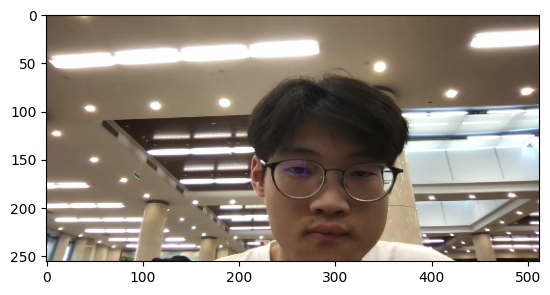

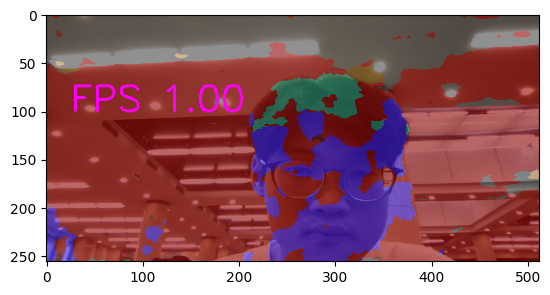

In [31]:
dataset = 'cityscapes'
model_name = 'FastSCNN'
capture_and_process_image(dataset, model_name, output_width=512, output_height=256)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/unet/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth


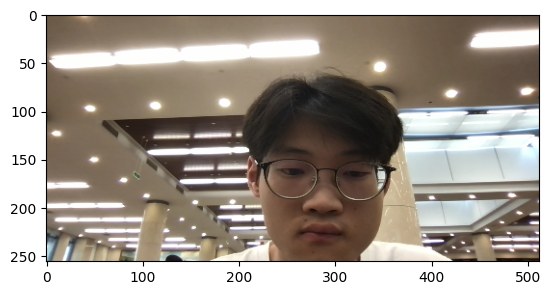

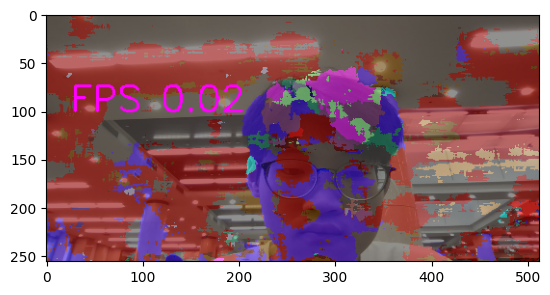

In [32]:
dataset = 'cityscapes'
model_name = 'UNet'
capture_and_process_image(dataset, model_name, output_width=512, output_height=256)

### 调用摄像头逐帧实时处理

In [ ]:
def RealtimeDetect(dataset, model_name):
    device = 'cpu'

    # 模型设置
    config_file, checkpoint_file = config(dataset, model_name)
    model = init_model(config_file, checkpoint_file, device=device)
    
    # 分割图像不同类别的配色设置
    palette_dict = config_palette(dataset)
    
    # 获取摄像头，传入0表示获取系统默认摄像头
    cap = cv2.VideoCapture(1)

    # 打开cap
    cap.open(0)

    # 无限循环，直到break被触发
    while cap.isOpened():
        
        # 获取画面
        success, frame = cap.read()
        
        if not success: # 如果获取画面不成功，则退出
            print('获取画面不成功，退出')
            break
        
        ## 逐帧处理
        frame = process_frame(frame, model, palette_dict)
        
        # 展示处理后的三通道图像
        cv2.imshow('my_window',frame)
        
        key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下

        if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
            break
        
    # 关闭摄像头
    cap.release()

    # 关闭图像窗口
    cv2.destroyAllWindows()

In [ ]:
dataset = 'cityscapes'
model_name = 'FastSCNN'
RealtimeDetect(dataset, model_name)

In [ ]:
dataset = 'ade20k'
model_name = 'deeplabv3+'
RealtimeDetect(dataset, model_name)